## Training a probabilsitic autoencoder to classify FeLoBAL

In [1]:
# import this package 
from pytorch_pae import AE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.table import Table
from scipy import stats
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from astropy.io import fits
# from specbox import SpecSDSS
import multiprocessing

In [3]:
# import pytorch
import torch

print(torch.__version__)

2.0.0


In [4]:
from torchinfo import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from scipy import stats
from scipy.signal import savgol_filter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from glob import glob
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Step 1: Choose your parameters

In [7]:
## data parameters
dataset       = 'FelobalSimple'
loc           = './Datasets'

# number of layers in networks
# n_layers     = 8
n_layers     = 6

### convolutional net specific parameters ###

### Convolutions
# number of channels in each layer for convolutional neural net
# out_channels = [16,16,16]
# out_channels = [3,3,3,3,1,1,1,1]# channel越大，模型越复杂
out_channels = [3,3,3,1,1,1]
# kernel sizes in each layer for conv net
# kernel_sizes = [3,3,3,3,3,3,3,3]# 最小为3，可以调大，越大对大一些的结构就更敏感（kernel size到1就跟mlp没区别了）
kernel_sizes = [3,3,3,3,3,3]
# padding values in each conv layer
# paddings     = [1,1,1,1,1,1,1,1] #TODO: add suport for 'VALID' and 'SAME'
paddings     = [1,1,1,1,1,1]
# stride values in each conv layer
# strides      = [1,1,1,1,1,1,1,1]# 不能超过3
strides      = [1,1,1,1,1,1]

### Pooling
# scaling factor in max pooling layer 
# scale_facs   = [1,1,1,1,1,1,1,1] 
scale_facs   = [1,1,1,1,1,1] 

### Normalization
# whether t0 apply a layer normalization after conv layer
# layer_norm   = [True,True,True,True,True,True,True,True,True]
layer_norm   = [True,True,True,True,True,True,True]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False# 仿射变换，可以改成True试试
#############################################


### fully connected net specific parameters ###

# output size of each fully connected layer
# out_sizes    = [256,128,128]
# whether to add a bias in each layer or not
# bias         = [True, True, True, True, True, True, True, True, True]
bias         = [True, True, True, True, True, True, True]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
# dropout_rate = [0.4,0.4,0.4,0.5,0.5,0.7,0.7,0.8]# 这是为了防止过拟合的，可以调低调成0，让它过拟合试试看能不能出来尖
# dropout_rate = [0,0,0,0,0,0,0,0]
dropout_rate = [0.4,0.4,0.5,0.5,0.7,0.8]

# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = True
# activation function after each layer

# activations  = ['ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU']
activations  = ['ReLU','ReLU','ReLU','ReLU','ReLU','ReLU','ReLU']

# ##############################################


########### general parameters ###########
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 64
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 1200

# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'conv'
decoder_type = 'conv'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = True
########################################


########## Training parameters #########
nepochs         = 200#和learning rate需要一起调整，epoch变小，learning rate就需要变大
batchsize       = 64
batchsize_valid = 128
initial_lr      = 1e-2

optimizer        = 'Adam'
# choose one of pytorch's or define your own
criterion1       = 'MSELoss'
criterion2       = 'MSELoss'
# when to switch from criterion1 to criterion2
ann_epoch        = 500

# choose one of pytorch's or define your own
scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}

##### Just for contrastive learning --> ignore
contrastive      = False
tau              = 0.05
hidden_dim       = 2
########################################

In [8]:
general_params      = {'input_c': input_c, 
                       'input_dim': input_dim, 
                       'latent_dim': latent_dim, 
                       'encoder_type': encoder_type, 
                       'decoder_type': decoder_type,
                       'contrastive':contrastive, 
                       'dim': dim, 
                       'hidden_dim':hidden_dim}
conv_network_params = {'n_layers': n_layers, 
                       'out_channels': out_channels, 
                       'kernel_sizes': kernel_sizes, 
                       'scale_facs': scale_facs, 
                       'paddings': paddings,
                       'strides': strides,
                       'activations': activations, 
                       'spec_norm': spec_norm, 
                       'layer_norm': layer_norm,
                       'affine': affine,
                       'final_sigmoid': final_sigmoid, 
                       'bias':bias}
# fc_network_params   = {'n_layers': n_layers, 
#                        'out_sizes': out_sizes,
#                        'activations': activations, 
#                        'spec_norm': spec_norm, 
#                        'dropout_rate':dropout_rate, 
#                        'layer_norm': layer_norm, 
#                        'affine': affine, 
#                        'final_sigmoid': final_sigmoid, 
#                        'bias':bias}

training_params     = {'batchsize': batchsize, 
                       'initial_lr': initial_lr, 
                       'optimizer': optimizer, 
                       'criterion1': criterion1, 
                       'criterion2': criterion2, 
                       'scheduler': scheduler, 
                       'scheduler_params':scheduler_params, 
                       'batchsize_valid': batchsize_valid, 
                       'ann_epoch':ann_epoch}
data_params         = {'dataset':dataset, 'loc': loc}

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float)

## Step 2: Set up and train the autoencoder

In [10]:
AE1 = AE.Autoencoder(params=general_params,
                     dparams=data_params,
                     nparams_enc=conv_network_params, 
                     nparams_dec=conv_network_params, 
                     tparams=training_params, 
                     device=device, 
                     transforms=None)

In [11]:
# summary?

In [12]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

/gpfs/share/home/1900011612/anaconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/gpfs/share/home/1900011612/anaconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [13]:
summary(AE1, (input_c, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 1, 1200]              --
├─ConvEncoder: 1-1                       [1, 64]                   --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Conv1d: 3-1                  [3, 1200]                 12
│    │    └─LayerNorm: 3-2               [3, 1200]                 --
│    │    └─ReLU: 3-3                    [3, 1200]                 --
│    │    └─AdaptiveMaxPool1d: 3-4       [3, 1200]                 --
│    │    └─Conv1d: 3-5                  [3, 1200]                 30
│    │    └─LayerNorm: 3-6               [3, 1200]                 --
│    │    └─ReLU: 3-7                    [3, 1200]                 --
│    │    └─AdaptiveMaxPool1d: 3-8       [3, 1200]                 --
│    │    └─Conv1d: 3-9                  [3, 1200]                 30
│    │    └─LayerNorm: 3-10              [3, 1200]                 --
│    │    └─ReL

In [14]:
AE1.train_loader.dataset.__getitem__([0])['features'].shape

torch.Size([1, 1200])

In [15]:
train_loss, valid_loss = AE1.train_autoencoder(nepochs)

epoch: 1, training loss: 1.3238e-02, validation loss: 9.6968e-03, learning rate: 1.0000e-02
epoch: 2, training loss: 7.4418e-03, validation loss: 6.6717e-03, learning rate: 9.8000e-03
epoch: 3, training loss: 6.9975e-03, validation loss: 7.7818e-03, learning rate: 9.6040e-03
epoch: 4, training loss: 6.9769e-03, validation loss: 6.2931e-03, learning rate: 9.4119e-03
epoch: 5, training loss: 6.6214e-03, validation loss: 6.7398e-03, learning rate: 9.2237e-03
epoch: 6, training loss: 6.6032e-03, validation loss: 6.9442e-03, learning rate: 9.0392e-03
epoch: 7, training loss: 6.6298e-03, validation loss: 6.6244e-03, learning rate: 8.8584e-03
epoch: 8, training loss: 6.6353e-03, validation loss: 7.0158e-03, learning rate: 8.6813e-03
epoch: 9, training loss: 6.1379e-03, validation loss: 5.9420e-03, learning rate: 8.5076e-03
saved model to "./AE.ckpt"
epoch: 10, training loss: 5.7436e-03, validation loss: 5.3415e-03, learning rate: 8.3375e-03
epoch: 11, training loss: 5.5740e-03, validation los

In [16]:
AE1.load_model('.')

True

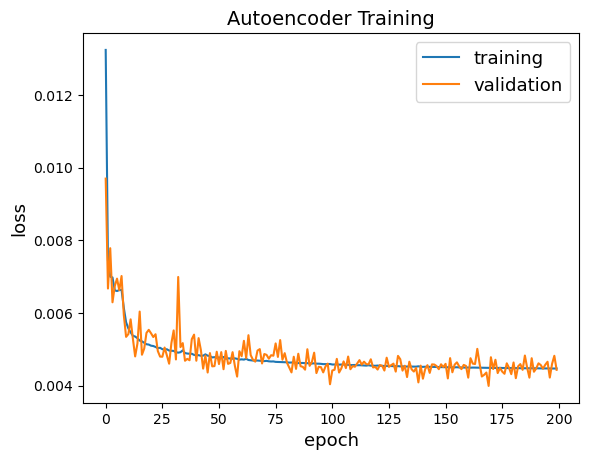

In [17]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.savefig('./Figures/PAE_v6/0-loss_curve.png')
plt.show()

## Data reconstructions

In [18]:
from pytorch_pae.data_loader import *

In [19]:
data_params['dataset']

'FelobalSimple'

In [20]:
train_loader, valid_loader, test_loader= get_data(data_params['dataset'],data_params['loc'],16, 16, transforms=None)

data = next(iter(train_loader))
data = data['features']
data = data.view(-1, 1, data.shape[1])

recon = AE1.forward(data.to(device))

In [21]:
torch.save(recon, os.path.join('./Models/Tutorials', 'recon'))

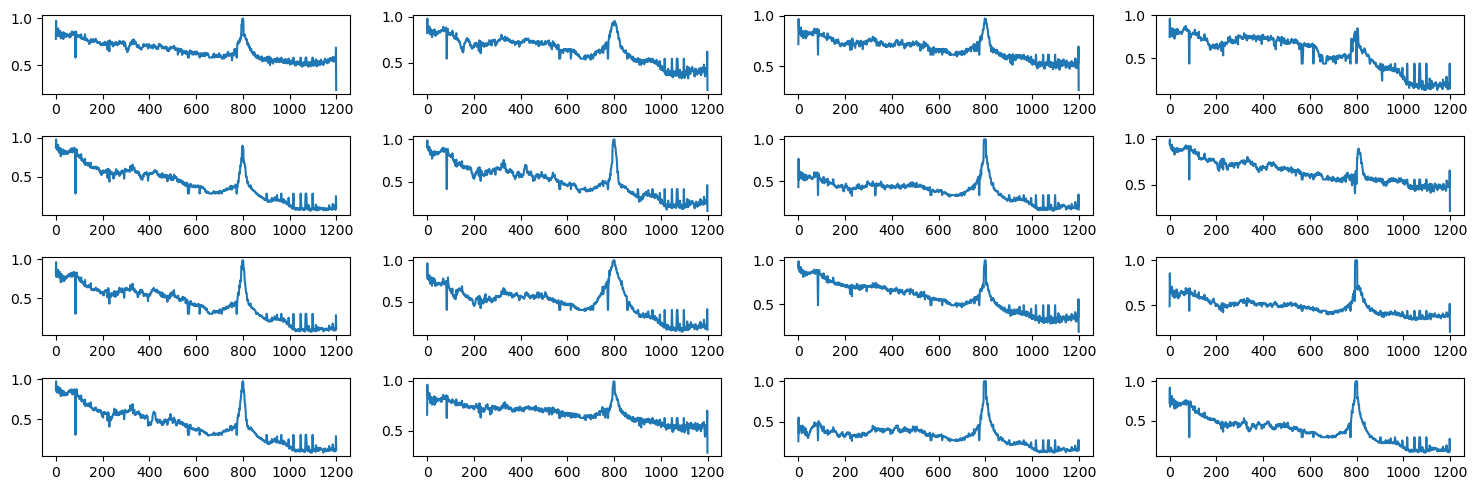

In [52]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(recon[ii].cpu().detach().numpy()))
#     ax[ii].set_title()
plt.tight_layout()
plt.savefig('./Figures/PAE_v6/1-recon')
plt.show()

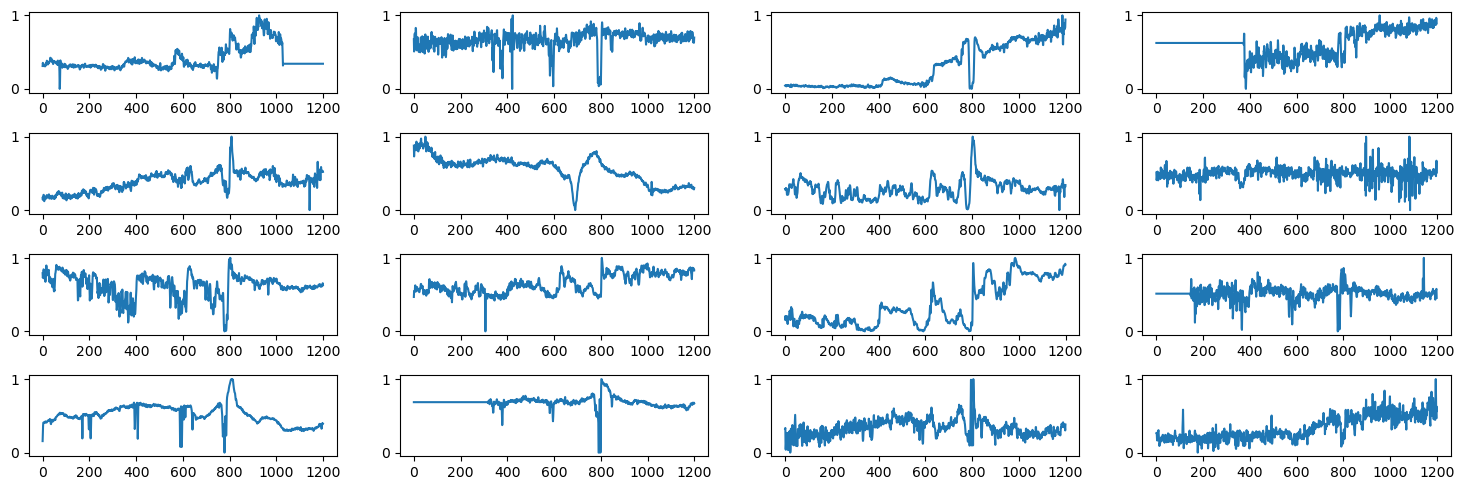

In [53]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data[ii].cpu().detach().numpy()))
plt.tight_layout()
plt.savefig('./Figures/PAE_v6/2-data')
plt.show()

In [24]:
from pathlib import Path
Path('Models/Tutorials').mkdir(exist_ok=True, parents=True)

In [25]:
torch.save(AE1, os.path.join('./Models/Tutorials', 'AE'))

## Step 3: Train the density estimator on the encoded data

In [26]:
# import density estimation module
from sinf import GIS

In [27]:
# load auutoencoder
AE1 = torch.load(os.path.join('./Models/Tutorials', 'AE'))

In [28]:
from pytorch_pae.data_loader import *

In [29]:
# encode data

train_loader, valid_loader, test_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1, transforms=None)

data = next(iter(train_loader))
data = data['features']
data = data.view(-1, 1, data.shape[1])
data = data.to(device)

valid_data = next(iter(valid_loader))
valid_data = valid_data['features']
valid_data = valid_data.view(-1, 1, valid_data.shape[1])
valid_data     = valid_data.to(device)

with torch.no_grad():
    encoded_train = AE1.encoder.forward(data)
    encoded_valid = AE1.encoder.forward(valid_data)

In [30]:
encoded_train.shape

torch.Size([71113, 64])

In [31]:
encoded_valid.shape

torch.Size([71113, 64])

In [32]:
encoded_train.device

device(type='cuda', index=0)

In [33]:
# train density estimator (set verbose=True to see training progress)
gis = GIS.GIS(data_train=encoded_train, 
              data_validate=encoded_valid,
              iteration=200,
              verbose=False, 
              nocuda=False)

/gpfs/share/home/1900011612/SINF/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1678402374358/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2425.)
  Q, R = torch.qr(ATi)


In [34]:
torch.save(gis, os.path.join('./Models/Tutorials', 'GIS'))

## Density Estimation and Outlier Detection

In [35]:
logps       = gis.evaluate_density(encoded_train)
logps_valid = gis.evaluate_density(encoded_valid)

In [36]:
logps       = logps.cpu().detach().numpy()
logps_valid = logps_valid.cpu().detach().numpy()

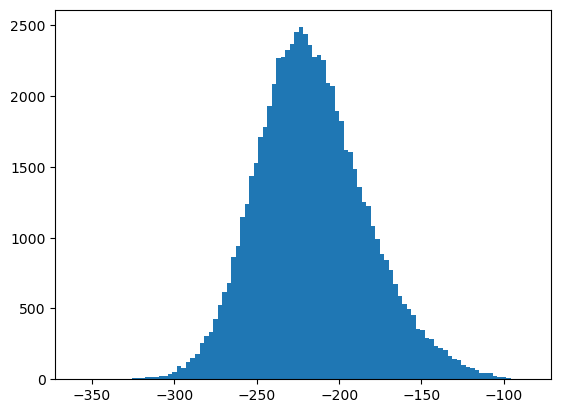

In [54]:
_       = plt.hist(logps,bins=100)
plt.savefig('./Figures/PAE_v6/3-prob_density')

In [38]:
ranking = np.argsort(logps)

### Digits with lowest probability

#### load dataset

In [46]:
df = pd.read_csv('./Datasets/train_dr16q+felostrong_v2.csv')

In [47]:
from os.path import basename

In [48]:
def make_basename(str_in):
    return basename(str_in).split('.')[0]

df['basename'] = df['filename'].apply(make_basename)

#### draw 16 samples

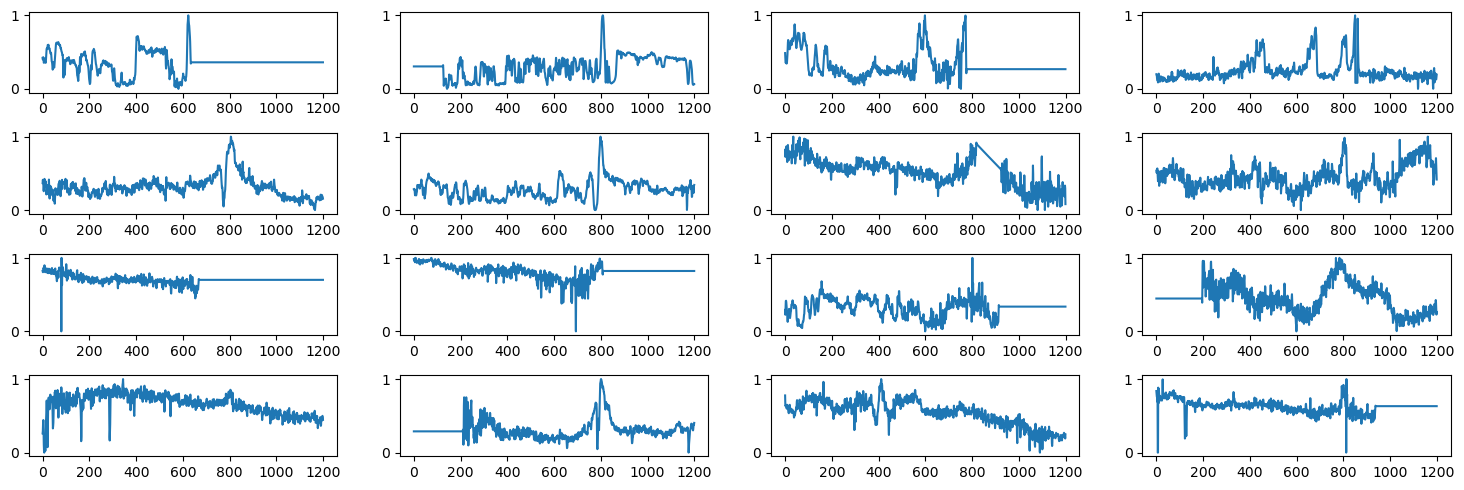

In [39]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data[ranking[ii]].cpu().detach().numpy()))
plt.tight_layout()

plt.show()

#### draw 160 samples

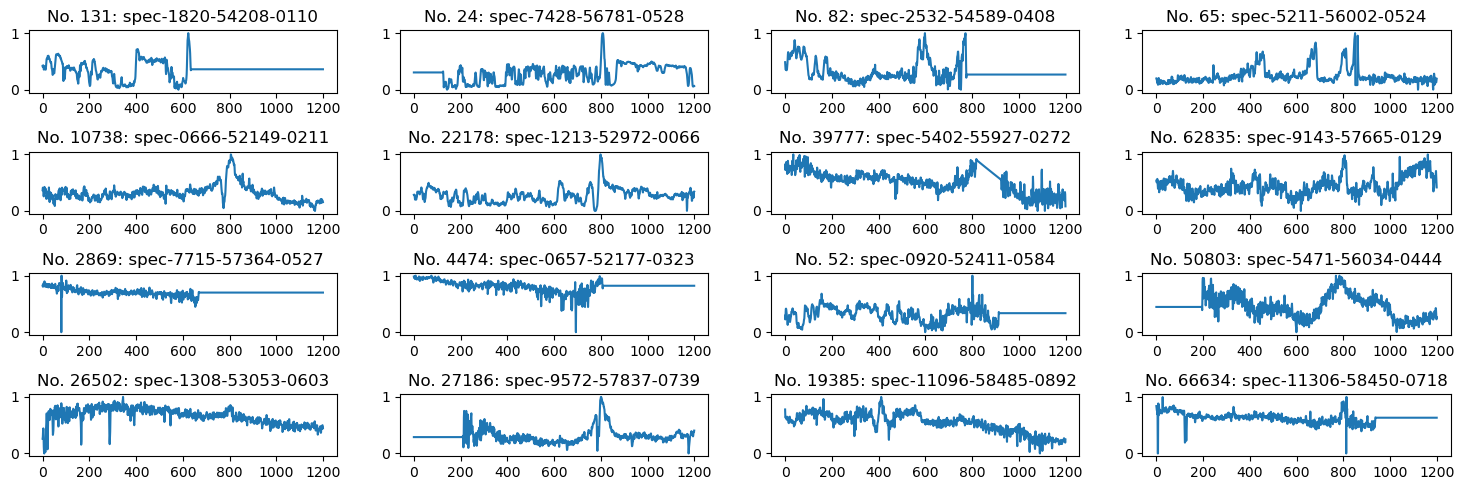

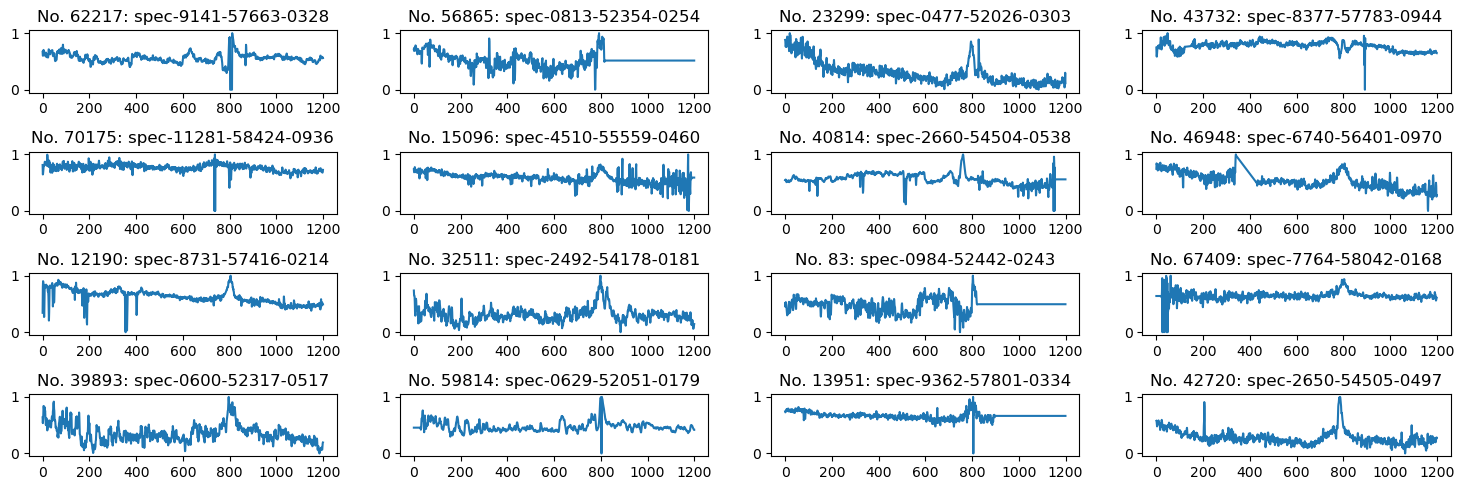

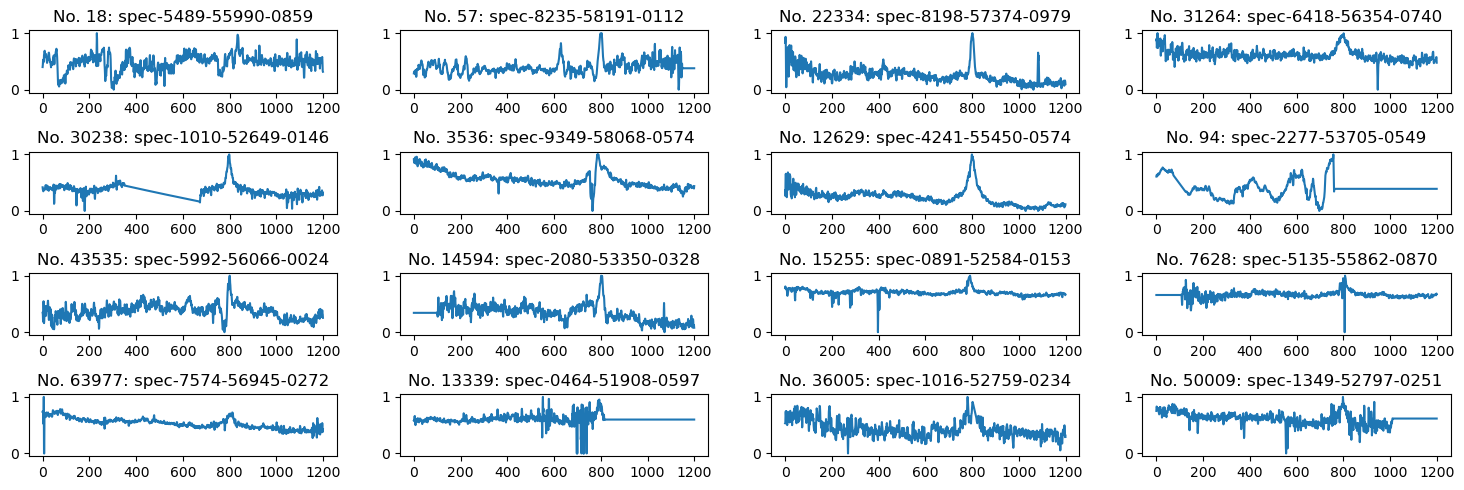

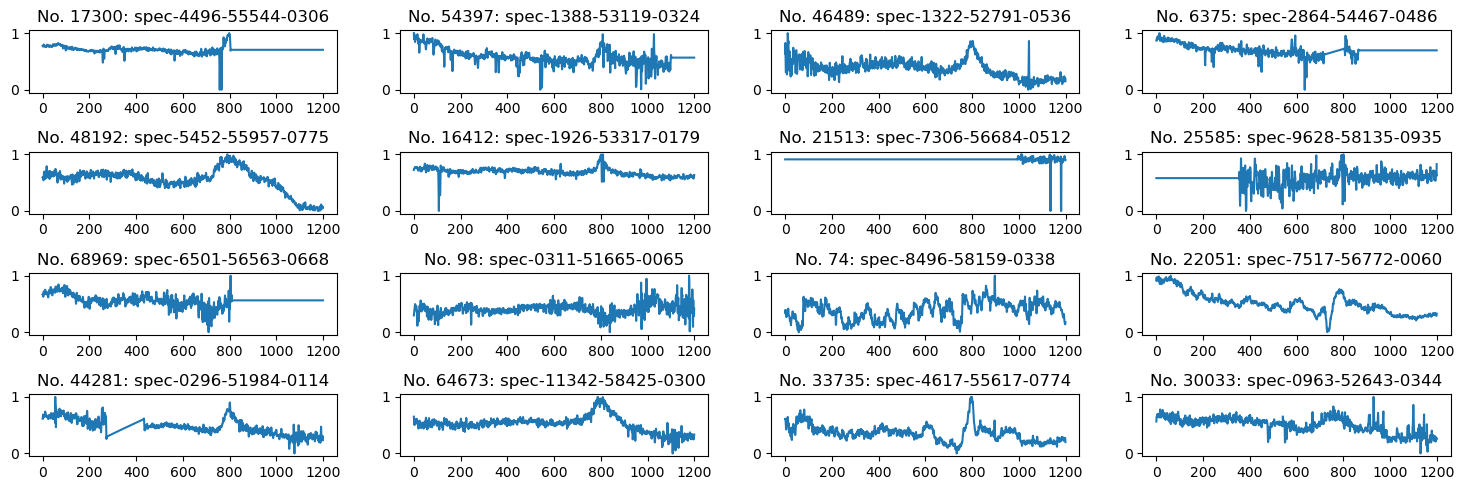

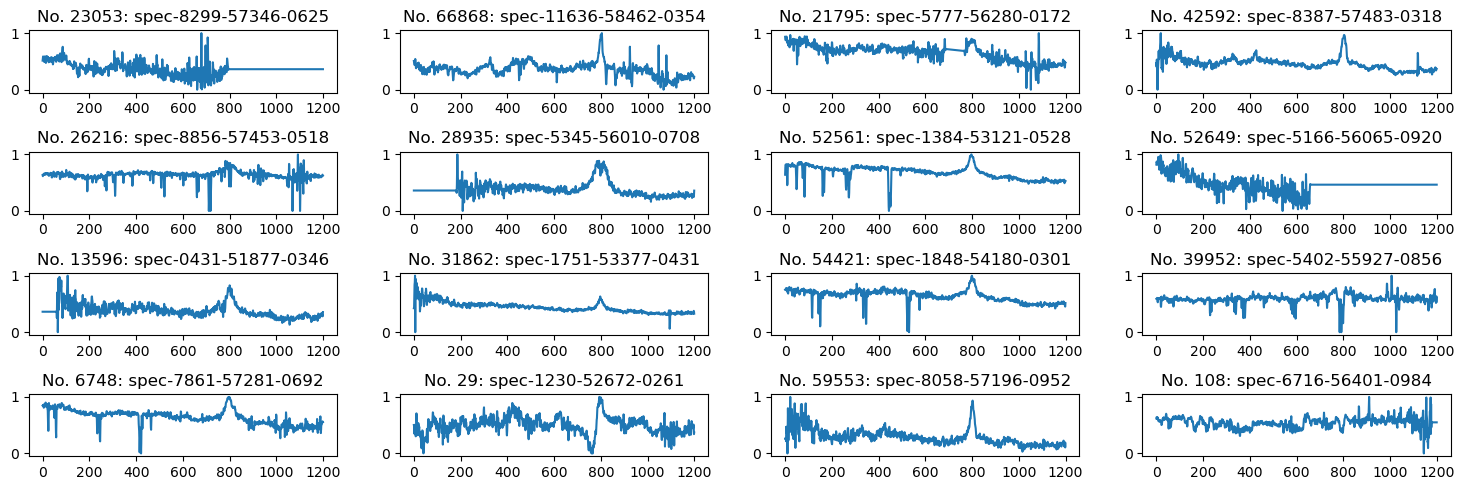

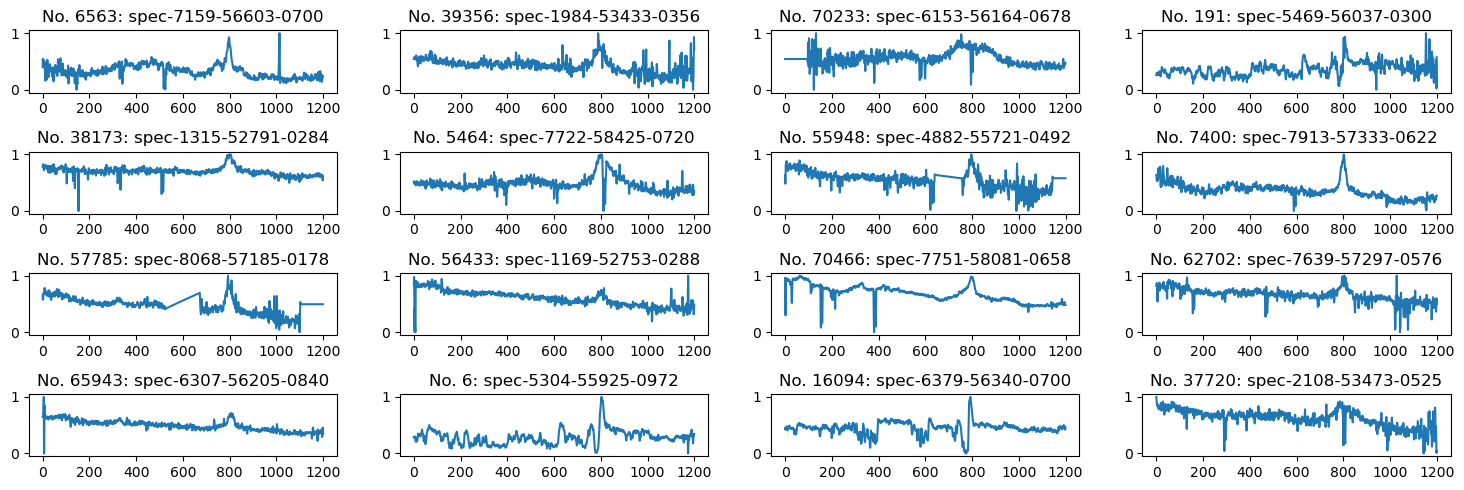

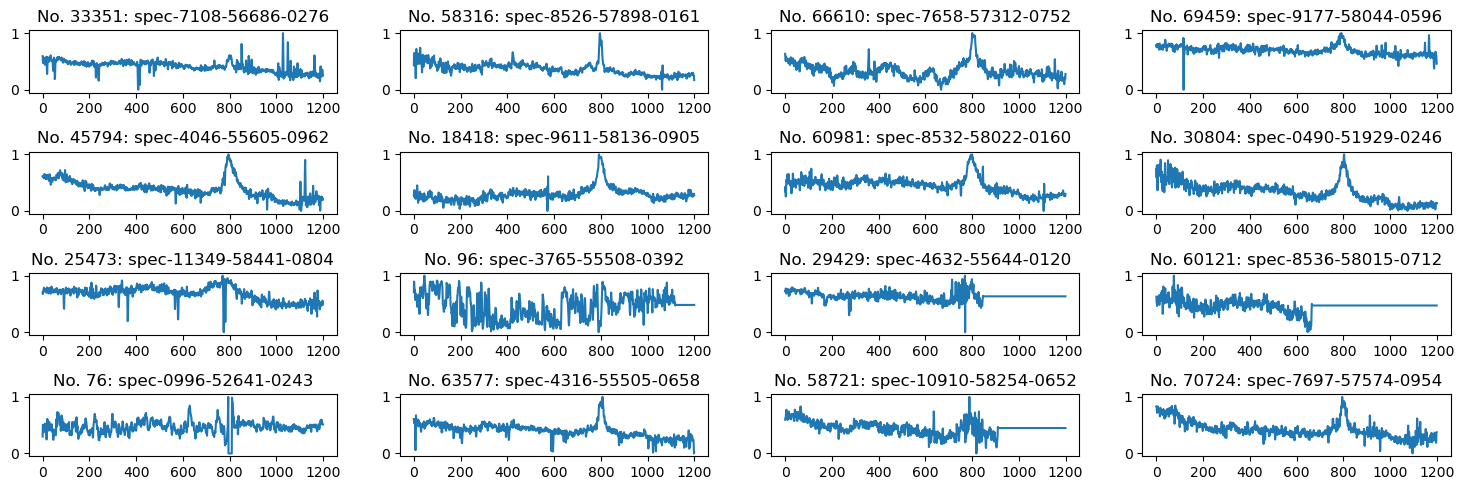

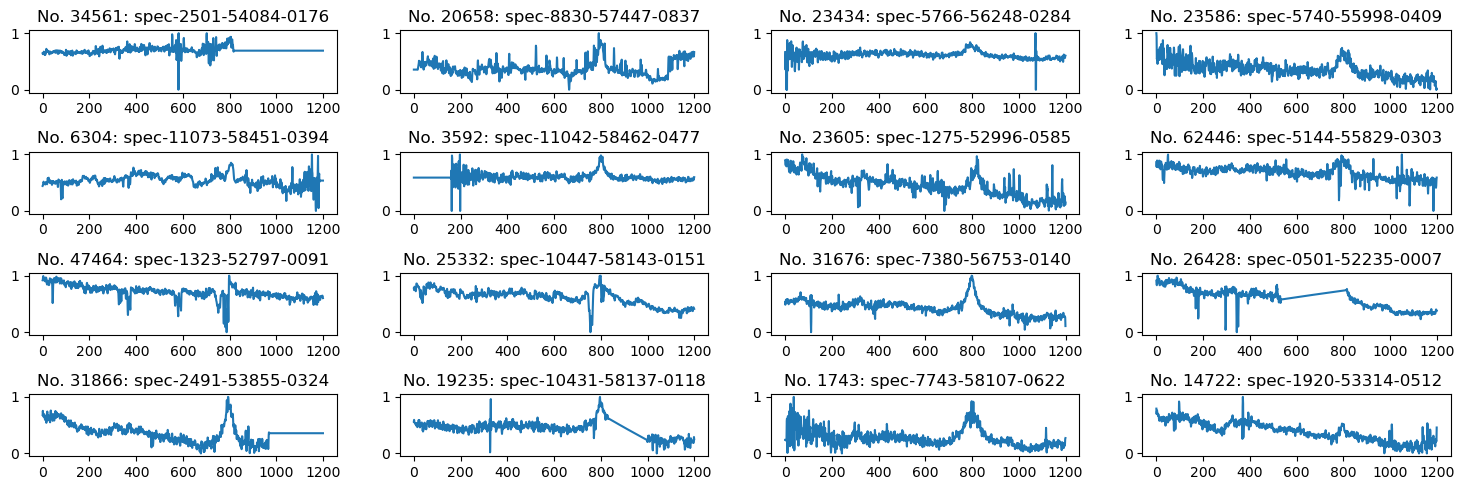

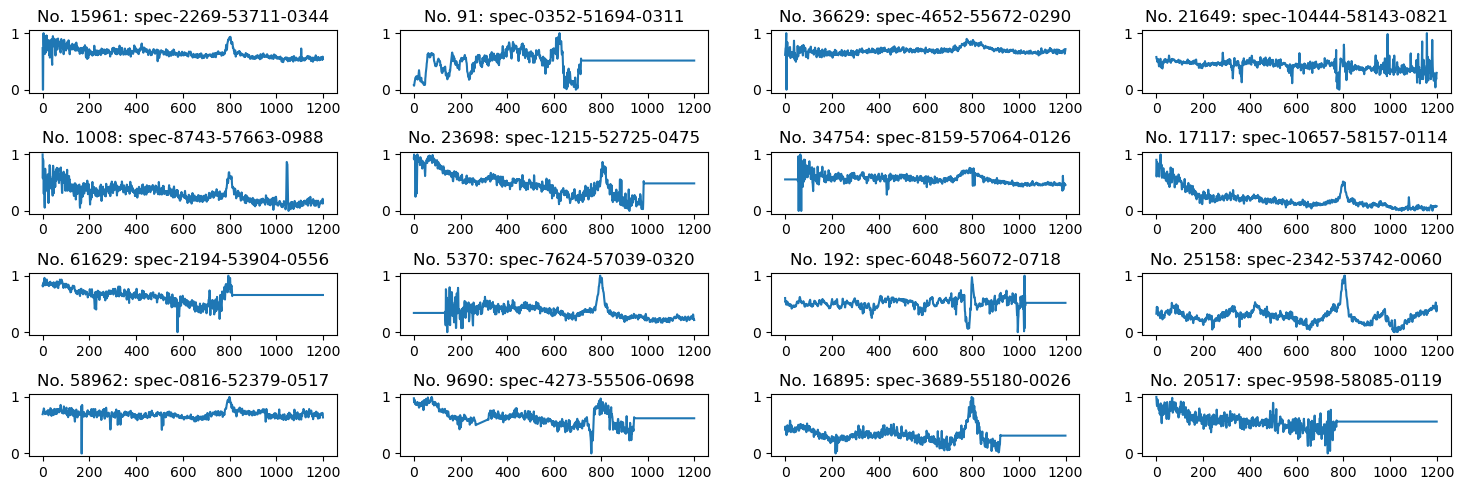

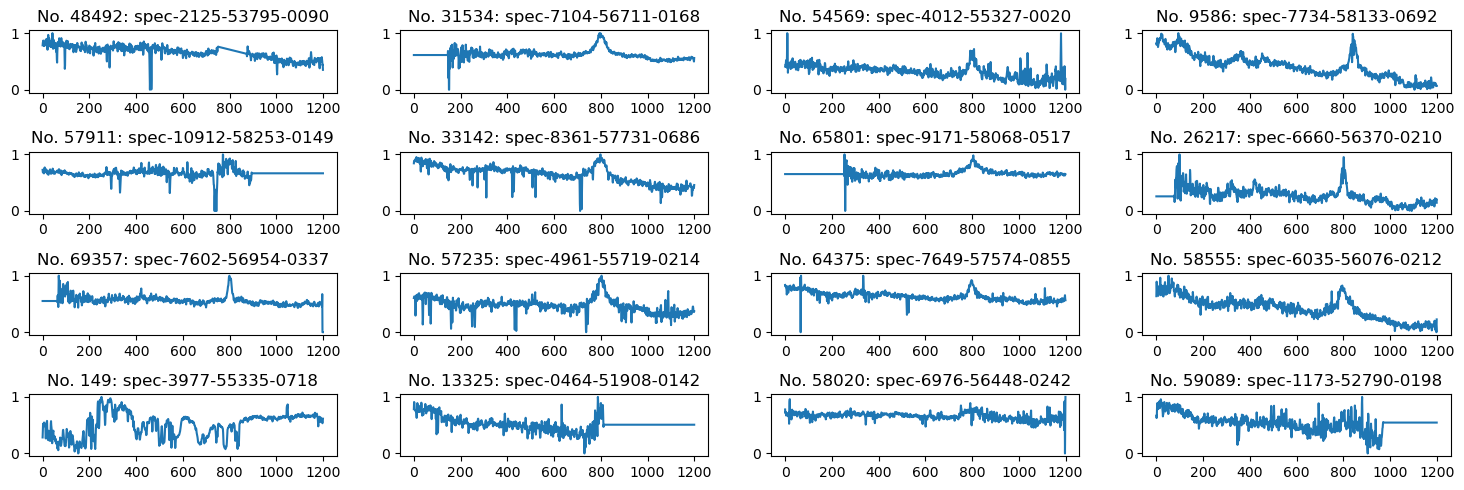

In [56]:
for i in range(10):
    fig, ax = plt.subplots(4,4,figsize=(15,5))
    ax = ax.flatten()
    for j in range(16):
        ax[j].plot(np.squeeze(data[ranking[16*i+j]].cpu().detach().numpy()))
        ax[j].set_title('No. {}: {}'.format(ranking[16*i+j], df['basename'][ranking[16*i+j]]))
    plt.tight_layout()
    fig_title = './Figures/PAE_v6/5-low_prob{}'.format(i)
    plt.savefig(fig_title)
    plt.show()

In [40]:
ranking[:16]

array([  131,    24,    82,    65, 10738, 22178, 39777, 62835,  2869,
        4474,    52, 50803, 26502, 27186, 19385, 66634])

In [41]:
np.squeeze(data[ranking[ii]].cpu().detach().numpy())

array([0.8378525 , 0.8024633 , 0.76320237, ..., 0.6320161 , 0.6320161 ,
       0.6320161 ], dtype=float32)

### Digits with highest probability

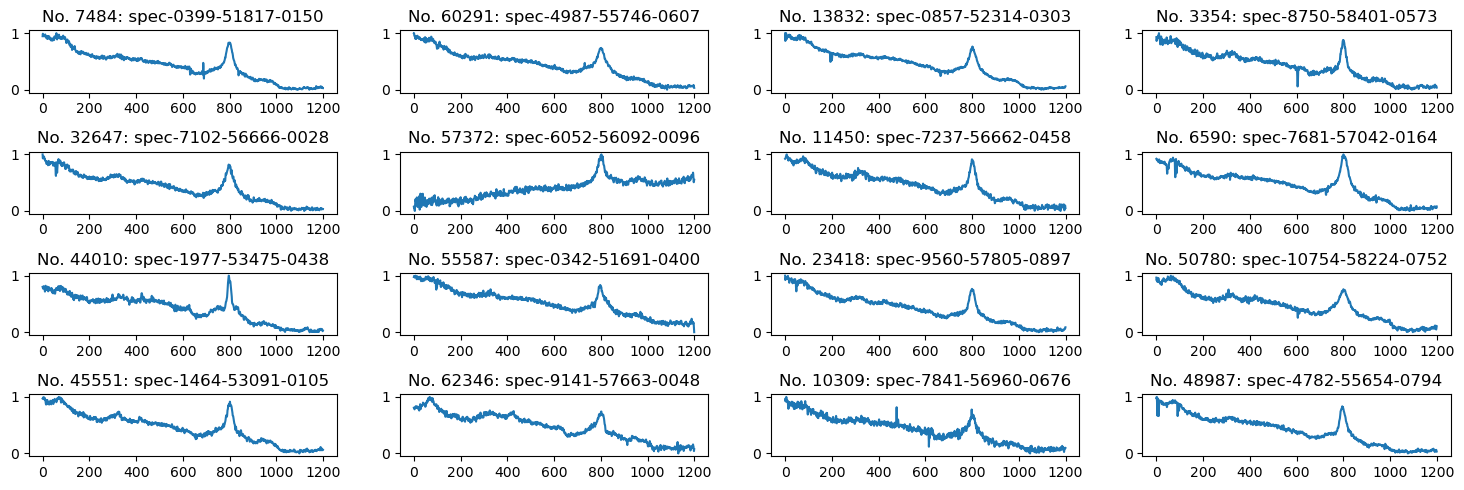

In [55]:
fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
ranking2 = ranking[::-1]
for ii in range(16):
    ax[ii].plot(np.squeeze(data[ranking2[ii]].cpu().detach().numpy()))
    ax[ii].set_title('No. {}: {}'.format(ranking2[ii], df['basename'][ranking2[ii]]))
plt.tight_layout()
plt.savefig('./Figures/PAE_v6/4-high_prob')
plt.show()

### Save logps to dataset

In [58]:
df['Logps'] = logps

In [59]:
df

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,filename,Label,redshift,basename,Logps
0,0.310855,0.353765,0.328653,0.312943,0.322027,0.314412,0.312898,0.318362,0.326978,0.316070,...,0.341651,0.341651,0.341651,0.341651,0.341651,./sdss_a/spec-0366-52017-0558.fits,FeLoStrong,2.039971,spec-0366-52017-0558,-247.007263
1,0.750673,0.622961,0.705251,0.769533,0.810645,0.705583,0.727385,0.773926,0.868956,0.861357,...,0.728531,0.748226,0.763840,0.714367,0.768348,./sdss_a/spec-0853-52374-0048.fits,FeLoStrong,1.305021,spec-0853-52374-0048,-252.739212
2,0.043366,0.039862,0.043455,0.046774,0.040403,0.033506,0.041997,0.047237,0.040251,0.038296,...,0.869629,0.813666,0.829250,0.838607,0.943321,./sdss_a/spec-7283-57063-0226.fits,FeLoStrong,2.227906,spec-7283-57063-0226,-181.850739
3,0.624621,0.624621,0.624621,0.624621,0.624621,0.624621,0.624621,0.624621,0.624621,0.624621,...,0.868442,0.915354,0.966365,0.947882,0.890697,./sdss_b/spec-2758-54523-0614.fits,FeLoStrong,0.607259,spec-2758-54523-0614,-178.489197
4,0.167267,0.140348,0.167441,0.171382,0.207855,0.205983,0.173348,0.121315,0.152535,0.163174,...,0.538204,0.525189,0.526343,0.531636,0.520601,./sdss_a/spec-5375-55973-0472.fits,FeLoStrong,1.809472,spec-5375-55973-0472,-206.759750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71108,0.336543,0.372973,0.389852,0.371757,0.351498,0.353121,0.376939,0.392493,0.388562,0.202186,...,0.112312,0.112260,0.097658,0.091399,0.078546,/store/public/databases/sdss_sample/new_eboss/...,DR16Q,1.181367,spec-7696-57655-0150,-173.170685
71109,1.000000,0.901511,0.910137,0.951153,0.948182,0.957183,0.936297,0.953151,0.904891,0.911121,...,0.055567,0.065542,0.070262,0.107965,0.025816,/store/public/databases/sdss_sample/new_eboss/...,DR16Q,0.847000,spec-6879-56539-0534,-191.056213
71110,0.388412,0.225739,0.259870,0.315850,0.285422,0.283763,0.251214,0.240525,0.245471,0.275326,...,0.192417,0.237023,0.197545,0.104932,0.121362,/store/public/databases/sdss_sample/new_eboss/...,DR16Q,1.782679,spec-7595-56957-0726,-262.038910
71111,0.890651,0.854669,0.852116,0.847721,0.838140,0.840658,0.874307,0.872411,0.849430,0.829005,...,0.707577,0.719013,0.652655,0.681928,0.655104,/store/public/databases/sdss_sample/new_eboss/...,DR16Q,0.715599,spec-7750-58402-0212,-226.312347


In [60]:
df1 = df.iloc[:,1200:]

In [61]:
df1.to_excel('./Figures/PAE_v6/low_prob_list.xlsx')

## Data Generation

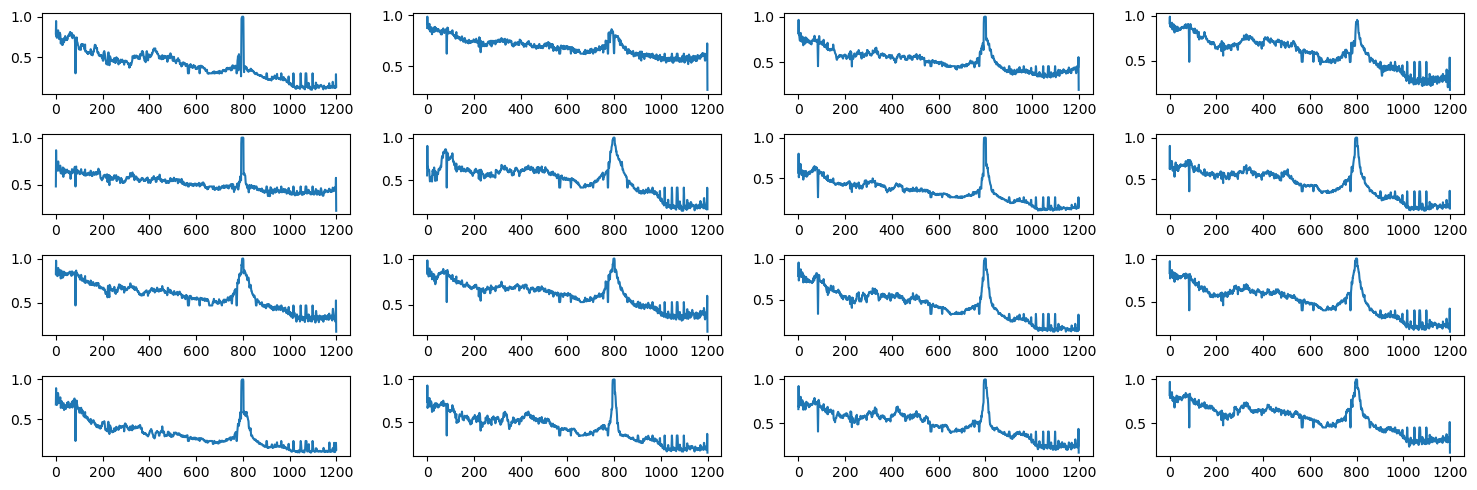

In [57]:
samples, _ = gis.sample(16)
with torch.no_grad():
    decoded_samples = AE1.decoder.forward(samples)

fig, ax = plt.subplots(4,4,figsize=(15,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(decoded_samples[ii].cpu().detach().numpy()))
plt.tight_layout()
plt.savefig('./Figures/PAE_v6/6-data_generation')
plt.show()